In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
from src.sympy_utilities import *
from src.BinaryEncodings import *
from src.MatrixToPauliString import *
from src.qiskit_utilities import *

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator

from ipywidgets import IntProgress
from IPython.display import display, clear_output 

import scipy.sparse.linalg

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import os
import json
import math

In [12]:
h_b_AHO = 0.5*(p*p) + 0.5*(m*q+g*q**3)**2
h_f_AHO = -0.5*(m+3*g*q*q)#[bdag,b]

cutoff=16

ham=Hamiltonian(h_b_AHO,h_f_AHO,{m:1, g:1}, cutoff, standard_encode)


In [4]:
hamOP = pauli_string_to_op(ham.pauliStrings)
nq=math.floor(math.log2(ham.hamMatrix.shape[0]))
if not math.log2(ham.hamMatrix.shape[0]).is_integer():
    nq+=1

In [5]:
estimator=Estimator()

In [9]:
if os.path.exists('Data/vqe_aho_real_amplitudes_l{}.json'.format(cutoff)):
    raFile=open('Data/vqe_aho_real_amplitudes_l{}.json'.format(cutoff))
    results=json.load(raFile)
else:
    results = {}    

vqeRuns=5

style = {'description_width': 'initial'}
layout = {'width':'600px'}

#for entanglement in ['linear','reverse_linear','circular','sca']: #full and reverse linear are same, reverse has less gates
for entanglement in ['linear','reverse_linear']:
    if entanglement not in results:
        results[entanglement]={}

    #for reps in [1,2,3,4]:  
    for reps in [1,2]:
        ansatz = RealAmplitudes(nq, entanglement=entanglement, reps=reps)
        vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=COBYLA(maxiter=5000*reps, tol=1e-4))
        
        values=[]
        iters=[]
        progress = IntProgress(min=0, max=vqeRuns, description="Running VQE with {} entanglement and {} reps".format(entanglement,reps), style=style, layout=layout)
        display(progress)

        for run in range(vqeRuns):
            result=vqe.compute_minimum_eigenvalue(hamOP)
            values.append(result.eigenvalue.real)
            iters.append(result.cost_function_evals)
            progress.value += 1
        
        if str(reps) in results[entanglement]:
            for value in values:
                results[entanglement][str(reps)]["eigenvalues"].append(value)
            for iter in iters:
                results[entanglement][str(reps)]["iters"].append(iter)

        else:
            results[entanglement][reps]={"eigenvalues": values, "iters": iters}
    
        with open('Data/vqe_aho_real_amplitudes_l{}.json'.format(cutoff),'w') as file:
            json.dump(results, file)
        
        clear_output()

1.0 0.018113235853476795 4199
2.0 0.007010898183423819 10000
1.05 0.01865337218269758 3455
2.05 0.04328705024053647 10000


Text(0.5, 1.0, 'RealAmplitudes')

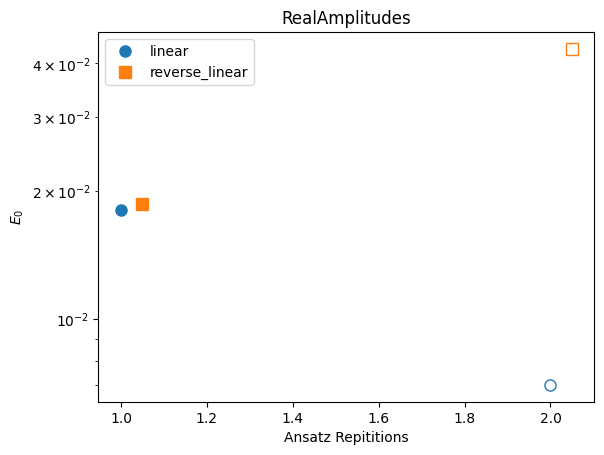

In [15]:
data={}
raFile=open('Data/vqe_aho_real_amplitudes_l{}.json'.format(cutoff))
#raFile=open('Data/vqe_linear_real_amplitudes_2kreps_1pm8.json')
data['RealAmplitudes']=json.load(raFile)
raFile.close()

amp='RealAmplitudes'
entanglements=data[amp].keys()

markersize=8
markers=['o','s','P','*']
colors=['tab:blue','tab:orange','tab:green','tab:red']

for i,entanglement in enumerate(entanglements):
    eMin = []
    iters = []
    reps=data[amp][entanglement].keys()

    for rep in reps:
        results=data[amp][entanglement][str(rep)]
        minIdx = np.argmin(np.array(results['eigenvalues']))
        eMin.append(results['eigenvalues'][minIdx])
        iters.append(results['iters'][minIdx])

    for rS, e, iter in zip(reps,eMin,iters):
        r=int(rS)
        print(r+0.05*i,e,iter)
        if iter==5000*r:
            plt.plot(r+0.05*i,e,marker=markers[i],markerfacecolor='none',markersize=markersize, color=colors[i])
        else:
            plt.plot(r+0.05*i,e,marker=markers[i],markersize=markersize, color=colors[i])

#    plt.scatter([int(r) for r in reps], eMin, marker=markers[i] ,label=entanglement)

plt.yscale('log')
plt.xlabel('Ansatz Repititions')
plt.ylabel(r'$E_0$')

lines = [mlines.Line2D([],[],color=colors[i], marker=markers[i], markersize=markersize, linestyle='None', label=ent) for i,ent in enumerate(entanglements)]

plt.legend(loc='upper left', handles=lines)
plt.title(amp)

In [16]:
print("------ cutoff = {} ------".format(cutoff))
#CLASSICAL COMPUTATION OF GROUND STATE ENERGY
ens=scipy.sparse.linalg.eigs(getMatrix(ham.pauliStrings),k=7,sigma=0.0)[0]
print("Lowest 7 energies = {}".format(ens))
print("Min energy = {:.4e}".format(np.array([x.real for x in ens]).min()))

------ cutoff = 16 ------
Lowest 7 energies = [1.83029849e-03-1.16375405e-18j 1.70732190e+00-6.42696091e-16j
 1.68720122e+00-3.30152421e-16j 4.41418952e+00-1.87450417e-14j
 4.37401524e+00-3.06784322e-16j 7.76596507e+00+2.08595202e-16j
 7.94769938e+00-6.74458509e-15j]
Min energy = 1.8303e-03
